In [10]:
import numpy as np
import pandas as pd
import os

# --- Configuration for Case 3 (Spiky Target in K-Clutter) ---
L_complex = 8          # Number of complex echoes
L_real = 2 * L_complex # 16 real inputs

# --- Power Parameters ---
CNR_dB = 10            # Clutter-to-Noise Ratio (Fixed Clutter Level)
SCR_dB = 9             # Signal-to-Clutter Ratio (Explicitly set to 9 dB)
# Note: Implied SNR = CNR + SCR = 19 dB

N_train = 50000        
N_valid = 10000        
N_H0_train = N_train // 2
N_H1_train = N_train // 2
N_H0_valid = N_valid // 2
N_H1_valid = N_valid // 2

# --- Case 3 Specific Parameters ---
nu_c = 0.5             # Clutter Shape Parameter (Small nu = Spiky/Heavy Tails)
nu_s = 0.5             # Target Shape Parameter (Spiky Target)
rho_c = 0            # Fixed Clutter Correlation Coefficient

# --- Parameter Calculation ---
noise_power = 1.0

# 1. Calculate Clutter Power
CNR_linear = 10**(CNR_dB / 10.0)
clutter_power = CNR_linear * noise_power

# 2. Calculate Signal Power based on SCR and Clutter Power
# SCR = Signal_Power / Clutter_Power  =>  Signal_Power = SCR * Clutter_Power
SCR_linear = 10**(SCR_dB / 10.0)
signal_power = SCR_linear * clutter_power 

# --- Helper Functions ---

def generate_complex_gaussian(N_samples, Cov_matrix):
    """Generates N_samples of complex Gaussian vectors z ~ NC(0, Cov_matrix)."""
    L = Cov_matrix.shape[0]
    Re_C = Cov_matrix.real
    Im_C = Cov_matrix.imag
    Sigma = 0.5 * np.block([[Re_C, -Im_C], [Im_C, Re_C]])
    X_real = np.random.multivariate_normal(np.zeros(2 * L), Sigma, N_samples)
    Z_complex = X_real[:, :L] + 1j * X_real[:, L:]
    return Z_complex

def complex_to_real_inputs(Z_complex):
    N_samples, L = Z_complex.shape
    X_real = np.zeros((N_samples, 2 * L))
    X_real[:, ::2] = Z_complex.real
    X_real[:, 1::2] = Z_complex.imag
    return X_real

def get_AR1_covariance(L, power, rho):
    """Generates AR(1) covariance matrix."""
    indices = np.arange(L)
    R = rho**np.abs(indices[:, None] - indices[None, :])
    return power * R

def generate_k_distributed_clutter(N_samples, L, power, rho, nu):
    """
    Generates K-distributed Clutter vectors.
    Model: c = sqrt(tau) * g
    tau ~ Gamma(nu, 1/nu)
    g ~ NC(0, M_c)
    """
    # 1. Generate Gaussian Speckle (g)
    C_speckle = get_AR1_covariance(L, power, rho)
    g = generate_complex_gaussian(N_samples, C_speckle)
    
    # 2. Generate Gamma Texture (tau)
    # Shape=nu, Scale=1/nu (so Mean = 1)
    tau = np.random.gamma(shape=nu, scale=1.0/nu, size=(N_samples, 1))
    
    # 3. Combine: c = sqrt(tau) * g
    c = np.sqrt(tau) * g
    return c

# --- Data Generation Function (Case 3) ---

def generate_case3_datasets(N_H0, N_H1, L_complex, signal_power, noise_power, clutter_power):
    """Generates dataset for Case 3: Spiky K-Target in K-Clutter + AWGN."""
    N_samples = N_H0 + N_H1
    
    # --- 1. Generate AWGN ---
    C_noise = noise_power * np.identity(L_complex)
    
    # --- 2. Generate H0 (K-Clutter + Noise) ---
    n_H0 = generate_complex_gaussian(N_H0, C_noise)
    c_H0 = generate_k_distributed_clutter(N_H0, L_complex, clutter_power, rho_c, nu_c)
    Z_H0_complex = c_H0 + n_H0
    
    # --- 3. Generate H1 (K-Target + K-Clutter + Noise) ---
    n_H1 = generate_complex_gaussian(N_H1, C_noise)
    c_H1 = generate_k_distributed_clutter(N_H1, L_complex, clutter_power, rho_c, nu_c)
    
    # Generate K-Target (Spiky)
    Z_s_H1 = np.zeros((N_H1, L_complex), dtype=complex)
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    tau_s_samples = np.random.gamma(shape=nu_s, scale=1.0/nu_s, size=N_H1)
    
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        tau_s = tau_s_samples[i]
        
        # Speckle Covariance (Power=signal_power)
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_speckle = signal_power * R_signal
        
        # Generate Speckle g
        g_s = generate_complex_gaussian(1, C_speckle).flatten()
        
        # Combine: s = sqrt(tau_s) * g_s
        Z_s_H1[i, :] = np.sqrt(tau_s) * g_s

    Z_H1_complex = Z_s_H1 + c_H1 + n_H1

    # --- 4. Combine and Format ---
    Z_complex = np.vstack([Z_H0_complex, Z_H1_complex])
    T_labels = np.concatenate([np.zeros(N_H0), np.ones(N_H1)])
    
    X_real = complex_to_real_inputs(Z_complex)
    
    indices = np.arange(N_samples)
    np.random.shuffle(indices)
    
    return X_real[indices], T_labels[indices]

# --- Dataset Generation ---
print(f"Generating Case 3 Training Data (SCR={SCR_dB}dB, CNR={CNR_dB}dB)...")
X_train, Y_train = generate_case3_datasets(
    N_H0_train, N_H1_train, L_complex, signal_power, noise_power, clutter_power
)
X_valid, Y_valid = generate_case3_datasets(
    N_H0_valid, N_H1_valid, L_complex, signal_power, noise_power, clutter_power
)

print(f"L (Real Inputs): {L_real}")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

Generating Case 3 Training Data (SCR=9dB, CNR=10dB)...
L (Real Inputs): 16
X_train shape: (50000, 16)
Y_train shape: (50000,)


(50000,)


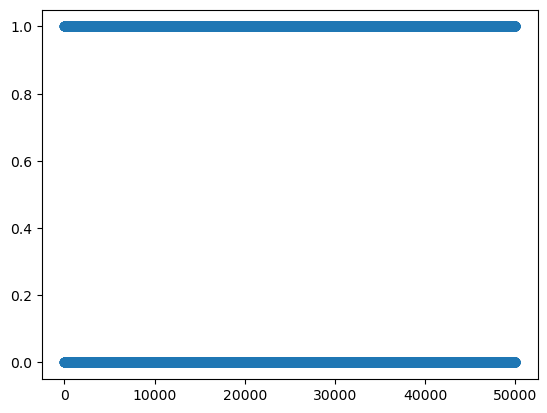

In [11]:
import matplotlib.pyplot as plt
idx = np.array(list(range(1, 50000 + 1)))
print(idx.shape)
plt.scatter(idx,Y_train)

1.0


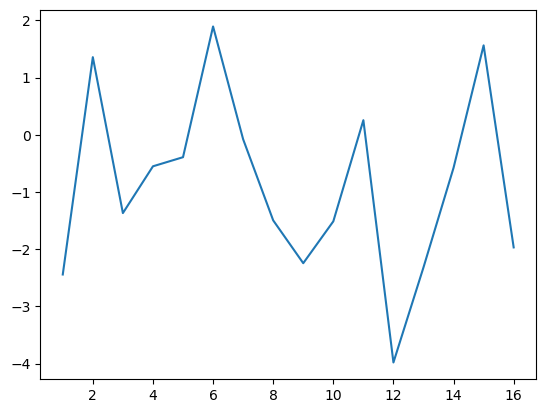

In [12]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[0])
print(Y_train[0])

1.0


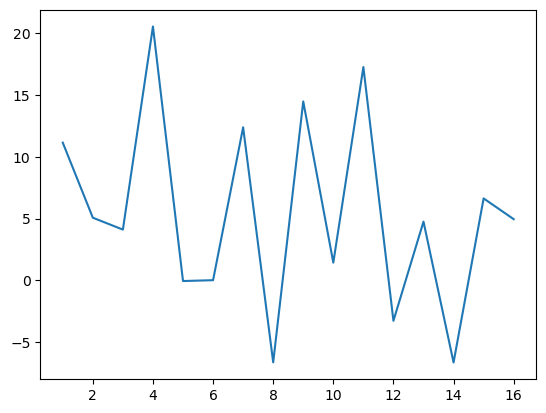

In [13]:
idx = idx = np.array(list(range(1, 16 + 1)))
plt.plot(idx,X_train[1])
print(Y_train[1])

In [14]:
import numpy as np

# --- Configuration for Case 3 Test ---
L_complex = 8         
L_real = 2 * L_complex 

# --- Power Parameters ---
CNR_dB = 10           # Clutter-to-Noise Ratio
SCR_dB = 9            # Signal-to-Clutter Ratio (Explicitly set to 9 dB)

N_H0_test = 20_000_000 # 2 * 10^7 patterns for H0
N_H1_test = 50_000     # 5 * 10^4 patterns for H1

# --- Case 3 Parameters ---
nu_c = 0.5
nu_s = 0.5
rho_c = 0

# --- Parameter Calculation ---
noise_power = 1.0

# 1. Calculate Clutter Power
CNR_linear = 10**(CNR_dB / 10.0)
clutter_power = CNR_linear * noise_power

# 2. Calculate Signal Power based on SCR and Clutter Power
SCR_linear = 10**(SCR_dB / 10.0)
signal_power = SCR_linear * clutter_power 

# --- Helper Functions (Must accompany the script) ---
# Ensure 'generate_complex_gaussian', 'complex_to_real_inputs', 
# 'get_AR1_covariance', and 'generate_k_distributed_clutter' 
# are defined or imported here.

# --- Test Data Generation Function (Case 3) ---

def generate_case3_test_data(N_H0, N_H1, L_complex, signal_power, noise_power, clutter_power):
    """
    Generates Test Dataset for Case 3: Spiky K-Target in K-Clutter.
    """
    
    # --- 1. Generate H0 (K-Clutter + Noise) ---
    print(f"Generating H0 test data ({N_H0} samples)...")
    
    C_noise = noise_power * np.identity(L_complex)
    n_H0 = generate_complex_gaussian(N_H0, C_noise)
    c_H0 = generate_k_distributed_clutter(N_H0, L_complex, clutter_power, rho_c, nu_c)
    
    Z_H0_complex = c_H0 + n_H0
    X_H0_real = complex_to_real_inputs(Z_H0_complex)
    T_H0_labels = np.zeros(N_H0)

    # --- 2. Generate H1 (K-Target + K-Clutter + Noise) ---
    print(f"Generating H1 test data ({N_H1} samples)...")
    
    n_H1 = generate_complex_gaussian(N_H1, C_noise)
    c_H1 = generate_k_distributed_clutter(N_H1, L_complex, clutter_power, rho_c, nu_c)
    
    # K-Target (Spiky)
    Z_s_H1 = np.zeros((N_H1, L_complex), dtype=complex)
    
    rho_t_samples = np.random.uniform(0, 1, N_H1)
    tau_s_samples = np.random.gamma(shape=nu_s, scale=1.0/nu_s, size=N_H1)
    
    for i in range(N_H1):
        rho_t = rho_t_samples[i]
        tau_s = tau_s_samples[i]
        
        indices = np.arange(L_complex)
        R_signal = rho_t**np.abs(indices[:, None] - indices[None, :])
        C_speckle = signal_power * R_signal
        
        g_s = generate_complex_gaussian(1, C_speckle).flatten()
        Z_s_H1[i, :] = np.sqrt(tau_s) * g_s
        
    Z_H1_complex = Z_s_H1 + c_H1 + n_H1
    X_H1_real = complex_to_real_inputs(Z_H1_complex)
    T_H1_labels = np.ones(N_H1)
    
    print("Test data generation complete.")
    return X_H0_real, T_H0_labels, X_H1_real, T_H1_labels

# --- Execution ---
print(f"Generating Test Data (SCR={SCR_dB}dB, CNR={CNR_dB}dB)...")
X_test_H0, Y_test_H0, X_test_H1, Y_test_H1 = generate_case3_test_data(
    N_H0_test, N_H1_test, L_complex, signal_power, noise_power, clutter_power
)

print(f"\nTest Set H0 Input shape: {X_test_H0.shape}")
print(f"Test Set H1 Input shape: {X_test_H1.shape}")

Generating Test Data (SCR=9dB, CNR=10dB)...
Generating H0 test data (20000000 samples)...
Generating H1 test data (50000 samples)...
Test data generation complete.

Test Set H0 Input shape: (20000000, 16)
Test Set H1 Input shape: (50000, 16)


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import time



# Architectures to be tested (MLP L/M/1 format from Figure 2)
HIDDEN_NEURONS = [23, 20, 17, 14] 
ARCHITECTURES = {M: f"MLP 16/{M}/1" for M in HIDDEN_NEURONS}


np.random.seed(42)


X_test = np.vstack((X_test_H0, X_test_H1))
Y_true = np.concatenate((Y_test_H0, Y_test_H1))



def build_mlp(M):
    """Builds the MLP 16/M/1 architecture with a valid Keras name."""
    # Use M as the valid name, and store the paper's label separately
    model_name = f"MLP_{M}" 
    model = keras.Sequential([
        keras.layers.Dense(M, activation='sigmoid', input_shape=(L_real,)), 
        keras.layers.Dense(1, activation='sigmoid')
    ], name=model_name)
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', # Cross-Entropy Error
        metrics=['accuracy']
    )
    return model

# --- Define Early Stopping Callback ---
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=200,
    restore_best_weights=True
)







In [16]:
import time
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# --- Phase 2: Training and Validation (with tqdm) ---
trained_models = {}

print("--- Starting MLP Training with Cross-Entropy Error ---")

# Outer loop: Use tqdm to track progress across different MLP architectures
for M in tqdm(HIDDEN_NEURONS, desc="Overall MLP Training"):
    name_label = ARCHITECTURES[M]
    print(f"\nTraining model: {name_label}")
    
    start_time = time.time()
    model = build_mlp(M)
    
    # Inner loop: Use TqdmCallback to show progress within the Keras model.fit
    # The list of callbacks now includes both EarlyStopping and TqdmCallback
    history = model.fit(
        X_train, Y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_valid, Y_valid),
        callbacks=[early_stop_callback, TqdmCallback(verbose=0)], # Add TqdmCallback
        verbose=0 # Ensure Keras's built-in verbosity is off
    )
    
    trained_models[M] = model
    end_time = time.time()
    
    # Manually extract the best validation loss and epoch for better reporting
    best_val_loss = min(history.history['val_loss'])
    best_epoch = np.argmin(history.history['val_loss']) + 1

    print(f"Training finished for {name_label}.")
    print(f"  > Epochs run: {len(history.history['loss'])}")
    print(f"  > Best Validation Loss ({best_val_loss:.4f}) achieved at Epoch: {best_epoch}")
    print(f"  > Total time: {end_time - start_time:.2f} seconds.")


print("\n--- Training Complete ---")

--- Starting MLP Training with Cross-Entropy Error ---


Overall MLP Training:   0%|          | 0/4 [00:00<?, ?it/s]/home/iiitbsarl/tools/miniforge3/envs/maskplace_gnn/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training model: MLP 16/23/1


Overall MLP Training:  25%|██▌       | 1/4 [03:05<09:16, 185.48s/it]

Training finished for MLP 16/23/1.
  > Epochs run: 200
  > Best Validation Loss (0.4239) achieved at Epoch: 123
  > Total time: 185.47 seconds.

Training model: MLP 16/20/1


Overall MLP Training:  50%|█████     | 2/4 [06:07<06:06, 183.41s/it]

Training finished for MLP 16/20/1.
  > Epochs run: 200
  > Best Validation Loss (0.4277) achieved at Epoch: 18
  > Total time: 181.97 seconds.

Training model: MLP 16/17/1


Overall MLP Training:  75%|███████▌  | 3/4 [09:08<03:02, 182.33s/it]

Training finished for MLP 16/17/1.
  > Epochs run: 200
  > Best Validation Loss (0.4277) achieved at Epoch: 184
  > Total time: 181.04 seconds.

Training model: MLP 16/14/1


Overall MLP Training: 100%|██████████| 4/4 [12:09<00:00, 182.45s/it]

Training finished for MLP 16/14/1.
  > Epochs run: 200
  > Best Validation Loss (0.4274) achieved at Epoch: 184
  > Total time: 181.32 seconds.

--- Training Complete ---


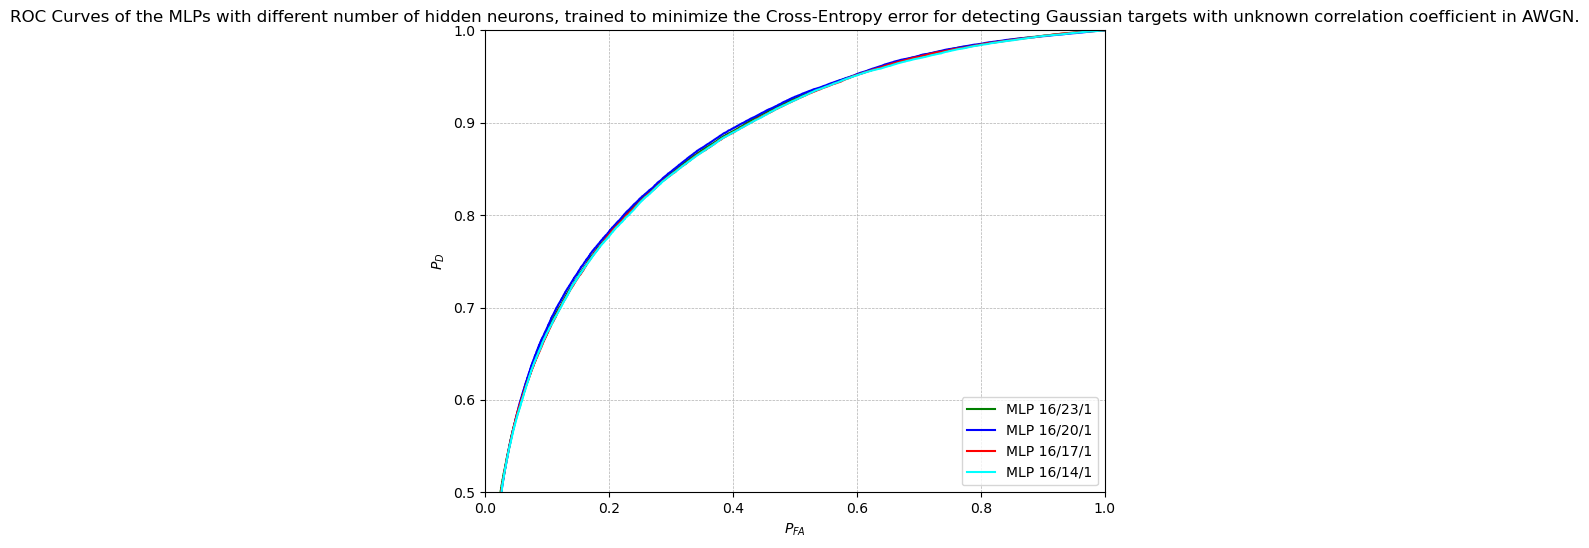

In [17]:
plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

fpr1 = []
tpr1 = []

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Predict the probability of H1 (target present)
    Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # Calculate ROC curve: PFA vs PD
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    roc_auc = auc(fpr, tpr)

    fpr1.append(fpr)
    tpr1.append(tpr)
    
    # Plot the ROC curve. Scale FPR (PFA) by 10^4 to match the figure's x-axis unit.
    plt.plot(fpr, tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the Cross-Entropy error for detecting Gaussian targets with unknown correlation coefficient in AWGN.')
plt.xlabel('$P_{FA}$')
plt.ylabel('$P_{D}$')
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) # Set major ticks at 0, 0.2, 0.4, ...
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

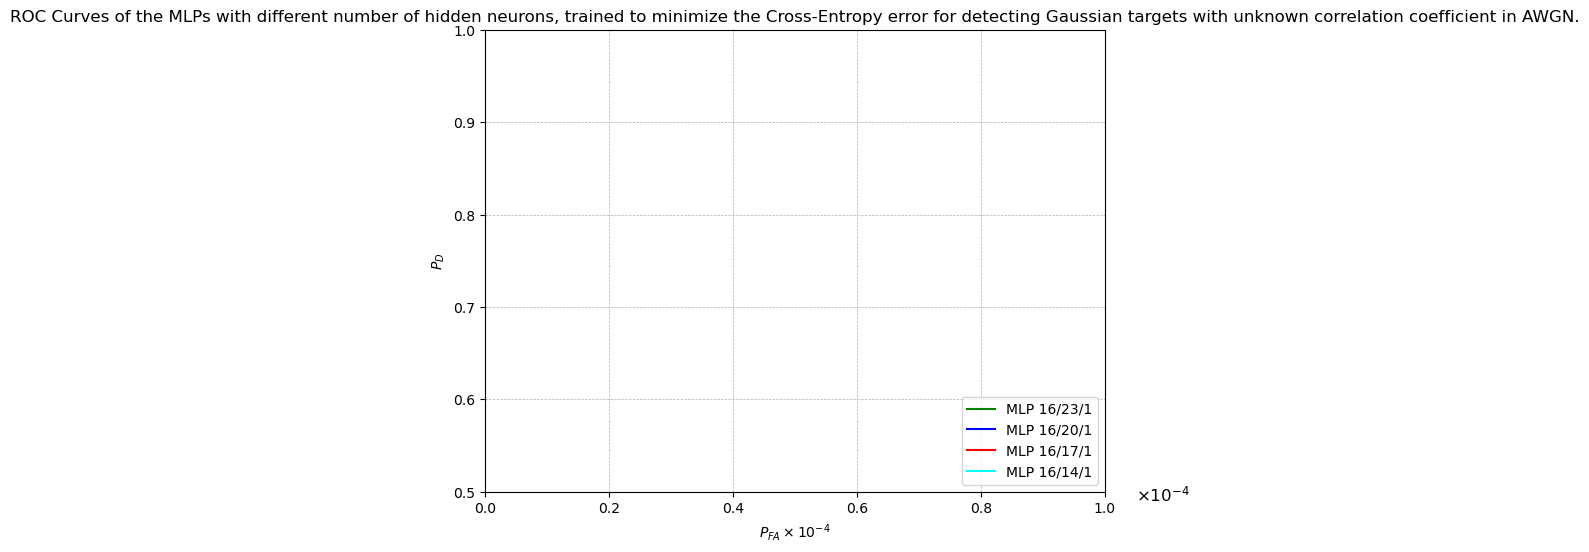

In [18]:
# --- Phase 3: ROC Curve Generation for Test Data (Corrected Scaling) ---

plt.figure(figsize=(8, 6))

colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    # model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # # Predict the probability of H1 (target present)
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    
    # # Calculate ROC curve: PFA vs PD
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    # roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve.
    # CRUCIAL CORRECTION: Scale FPR (PFA) by 1e4 to match the figure's X-axis units (PFA * 10^-4).
    plt.plot(fpr1[ITERATOR] * 1e2, tpr1[ITERATOR], 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of the MLPs with different number of hidden neurons, trained to minimize the Cross-Entropy error for detecting Gaussian targets with unknown correlation coefficient in AWGN.')

# CRUCIAL CORRECTION: Update X-axis label to show the scaling
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

# CRUCIAL CORRECTION: Limit X-axis range to match the figure's zoomed view (0 to 1 in 10^-4 units)
plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

# Add the X-axis exponent label below the ticks to fully match the figure style
plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()


In [ ]:
# import numpy as np

# # --- Configuration (Must be consistent with data generation) ---
# L_complex = 8         
# L_real = 2 * L_complex 
# SNR_dB = 7            
# noise_power = 1.0
# SNR_linear = 10**(SNR_dB / 10.0)
# signal_power = SNR_linear * noise_power

# # --- Helper Functions (Filter and Covariance) ---

# def real_to_complex_vectors(X_real):
#     """Converts real inputs (N x 2Lc) back to complex vectors (N x Lc)."""
#     N_samples, L_real = X_real.shape
#     L_complex = L_real // 2
#     Z_complex = X_real[:, ::2] + 1j * X_real[:, 1::2]
#     return Z_complex

# def get_signal_covariance(L, signal_power, rho_t):
#     """Generates the AR(1) signal covariance matrix Cs = sigma_s^2 * R."""
#     indices = np.arange(L)
#     R = rho_t**np.abs(indices[:, None] - indices[None, :])
#     return signal_power * R

# def apply_matched_filter_power(z, C_inv):
#     """
#     Calculates the power output of the optimal filter: z^H C_inv z.
#     C_inv is the inverse of the interference covariance matrix (the optimal filter).
#     """
#     # z is Lcx1 column vector
#     # z.conj().T @ C_inv @ z is the quadratic form (output power)
#     quadratic_form = z.conj().T @ C_inv @ z
#     # Ensure result is a real scalar
#     return np.real(quadratic_form)[0, 0]

# # --- CGLR Score Generation Function (The Optimizer) ---

# def calculate_cglr_test_statistic_intuitive(Z_complex, L_complex, signal_power, noise_power):
#     """
#     Calculates the CGLR LLR score by maximizing the Log-Likelihood Ratio (LLR) 
#     over the unknown correlation coefficient rho_t.
#     """
#     N_samples = Z_complex.shape[0]
#     T_cglr = np.zeros(N_samples)
    
#     # Noise covariance is fixed (AWGN)
#     C_noise = noise_power * np.identity(L_complex)
#     C_noise_inv = np.linalg.inv(C_noise)
    
#     # Pre-calculate constant term for H0 (Noise Only) LLR
#     log_det_H0 = np.log(np.linalg.det(C_noise).real)
    
#     # Range of correlation coefficients (rho_t) to search over
#     RHO_T_GRID = np.linspace(0.01, 1.0, 100)
    
#     # Iterate over all complex sample vectors (Input to the Detector)
#     for i in range(N_samples):
#         z = Z_complex[i, :].reshape(-1, 1) # Lcx1 column vector
        
#         # 1. H0 Filter Output Power (Noise Only)
#         power_H0 = apply_matched_filter_power(z, C_noise_inv)
#         log_L_H0 = -(log_det_H0 + power_H0) # -Log-Likelihood
        
#         # 2. H1: Maximize Filter Output over unknown rho_t (The CGLR Step)
#         max_log_L_H1 = -np.inf
        
#         for rho_t in RHO_T_GRID:
#             C_signal = get_signal_covariance(L_complex, signal_power, rho_t)
#             C_H1 = C_signal + C_noise
            
#             try:
#                 # The Adaptive Filter for H1 interference (Filter is C_H1_inv)
#                 C_H1_inv = np.linalg.inv(C_H1)
                
#                 # Output Power of the Filter: z^H C_H1^-1 z
#                 power_H1 = apply_matched_filter_power(z, C_H1_inv)
#                 log_det_H1 = np.log(np.linalg.det(C_H1).real)
                
#                 # -Log-Likelihood for this specific rho_t
#                 log_L_H1_current = -(log_det_H1 + power_H1)
                
#                 if log_L_H1_current > max_log_L_H1:
#                     max_log_L_H1 = log_L_H1_current
            
#             except np.linalg.LinAlgError:
#                 continue 

#         # 3. CGLR Test Statistic = Log-Likelihood Ratio (LLR)
#         # LLR = log(max_rho_t(L(H1))) - log(L(H0))
#         T_cglr[i] = max_log_L_H1 - log_L_H0
        
#     return T_cglr

# # --- CGLR Score Generation ---
# # Note: Ensure X_test_H0 and X_test_H1 are properly loaded before running this part.

# print("Calculating CGLR test statistic for H0 test data...")
# Z_test_H0_complex = real_to_complex_vectors(X_test_H0)
# CGLR_scores_H0 = calculate_cglr_test_statistic_intuitive(Z_test_H0_complex, L_complex, signal_power, noise_power)

# print("Calculating CGLR test statistic for H1 test data...")
# Z_test_H1_complex = real_to_complex_vectors(X_test_H1)
# CGLR_scores_H1 = calculate_cglr_test_statistic_intuitive(Z_test_H1_complex, L_complex, signal_power, noise_power)

# # ... (ROC calculation and plotting code follows)

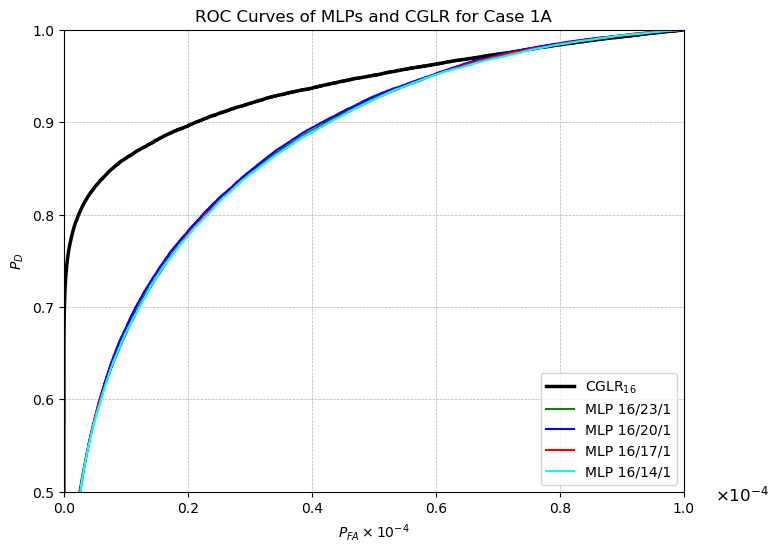

In [19]:
# # Combine scores and true labels for ROC calculation
# CGLR_Y_pred = np.concatenate([CGLR_scores_H0, CGLR_scores_H1])
# CGLR_Y_true = np.concatenate([Y_test_H0, Y_test_H1])

# # Calculate ROC for CGLR
# fpr_cglr, tpr_cglr, thresholds_cglr = roc_curve(CGLR_Y_true, CGLR_Y_pred)
import pandas as pd
cglr_df = pd.read_excel("cglr_metrics_SW1_case1a.xlsx")
fpr_cglr = cglr_df['FPR']
tpr_cglr = cglr_df['TPR']
thresholds_cglr = cglr_df['Thresholds']

# --- Final Plotting (Requires previous MLP training results) ---
# Assuming the MLP results (trained_models) are still in scope.

plt.figure(figsize=(8, 6))

# Plot CGLR (The black line in Figure 2)
plt.plot(fpr_cglr, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr , tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Combine scores and true labels for ROC calculation
CGLR_Y_pred = np.concatenate([CGLR_scores_H0, CGLR_scores_H1])
CGLR_Y_true = np.concatenate([Y_test_H0, Y_test_H1])

# Calculate ROC for CGLR
fpr_cglr, tpr_cglr, thresholds_cglr = roc_curve(CGLR_Y_true, CGLR_Y_pred)

# --- Final Plotting (Requires previous MLP training results) ---
# Assuming the MLP results (trained_models) are still in scope.

plt.figure(figsize=(8, 6))

# Plot CGLR (The black line in Figure 2)
plt.plot(fpr_cglr*1e2, tpr_cglr, 
         label=f'CGLR$_{{{L_real}}}$', 
         color='black', 
         linewidth=2.5)

# Plot MLPs (Same loop as before)
colors = {23: 'green', 20: 'blue', 17: 'red', 14: 'cyan'}
line_styles = {23: '-', 20: '-', 17: '-', 14: '-'}

ITERATOR = 0

for M in HIDDEN_NEURONS:
    model = trained_models[M]
    name_label = ARCHITECTURES[M]
    
    # Y_pred_proba = model.predict(X_test, verbose=0).flatten()
    # fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_proba)
    fpr = fpr1[ITERATOR]
    tpr = tpr1[ITERATOR]
    
    # Plot the MLP curve with the corrected x-axis scaling
    plt.plot(fpr*1e2 , tpr, 
             label=f'{name_label}', 
             color=colors[M], 
             linestyle=line_styles[M], 
             linewidth=1.5)
    
    ITERATOR += 1

# --- Plotting Configuration to Match Figure 2 ---
plt.title('ROC Curves of MLPs and CGLR for Case 1A')
plt.xlabel('$P_{FA} \\times 10^{-4}$') 
plt.ylabel('$P_{D}$')

plt.xlim(0, 1) 
plt.ylim(0.5, 1.0) 
plt.xticks(np.arange(0, 1.1, 0.2)) 

plt.text(1.05, 0.49, r'$\times 10^{-4}$', fontsize=12, ha='left')

plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd
df = pd.DataFrame({
    'FPR': fpr_cglr,
    'TPR': tpr_cglr,
    'Thresholds': thresholds_cglr
})

# Write the DataFrame to an Excel file
df.to_excel('cglr_metrics_gaussian.xlsx', index=False)

print("Data saved to cglr_metrics_gaussian.xlsx")

In [ ]:
fpr_cglr.shape